## This notebook is the baseline model using BioBert to generate embeddings

In [82]:
import pandas as pd
import dgl 
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
# import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

from transformers import BertTokenizer, BertModel
from transformers import BertConfig, BertForPreTraining, load_tf_weights_in_bert

import matplotlib.pyplot as plt

#### 0. Download BioBert from Repo

I've not included this as part of my submission repo so this cell will need to be run to download the models

In [3]:
!wget -O scibert_uncased.tar https://github.com/naver/biobert-pretrained/releases/download/v1.1-pubmed/biobert_v1.1_pubmed.tar.gz
!tar -xvf scibert_uncased.tar
!cp biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json

In [4]:
# Load biobert
def convert_tf_checkpoint_to_pytorch(tf_checkpoint_path, bert_config_file, pytorch_dump_path):
    # Initialise PyTorch model
    config = BertConfig.from_json_file(bert_config_file)
    print("Building PyTorch model from configuration: {}".format(str(config)))
    model = BertForPreTraining(config)

    # Load weights from tf checkpoint
    load_tf_weights_in_bert(model, config, tf_checkpoint_path)

    # Save pytorch-model
    print("Save PyTorch model to {}".format(pytorch_dump_path))
    torch.save(model.state_dict(), pytorch_dump_path)

convert_tf_checkpoint_to_pytorch("biobert_v1.1_pubmed/model.ckpt-1000000", 
                                 "biobert_v1.1_pubmed/bert_config.json", 
                                 "biobert_v1.1_pubmed/pytorch_model.bin")

Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



2025-01-05 22:27:09.427256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Save PyTorch model to biobert_v1.1_pubmed/pytorch_model.bin


#### 1. Read in files, and reduce problem statement to only nodes present in ground truth 

I've limited the sample space due to computational limitations. It will only consider the nodes and edges that have been labelled from the ground truth file

In [5]:
edges = pd.read_csv('input/Edges.csv', index_col=0)
ground = pd.read_csv('processed/ground_split.csv')
nodes = pd.read_csv('input/Nodes.csv', index_col=0)

In [6]:
# get all node names in the ground truth
unique_nodes = pd.DataFrame(set(ground.source).union(set(ground.target)), columns=['gt_nodes'])

# reduce problem statement to only take nodes that are in the source or target from the ground truth 
baseline_nodes = pd.merge(left=unique_nodes, right=nodes, left_on='gt_nodes', right_on='id', how='inner')
baseline_nodes = baseline_nodes[['id','name', 'category', 'description']]
baseline_nodes = baseline_nodes.reset_index()

# give new nodes a unique id - requirement of dgl
# note: dgl has support for named nodes but I was having issues here due to special characters
baseline_nodes_dict = dict(zip(baseline_nodes.id, baseline_nodes.index))

In [7]:
# map ground truth source and target names to ids provided by baseline node dictionary
ground.source = ground.source.apply(lambda x: baseline_nodes_dict[x])
ground.target = ground.target.apply(lambda x: baseline_nodes_dict[x])

#### 2. Split edges into train, test and validation sets

In [8]:
# train set - positive and negative nodes and edges
train_pos_u = np.array(ground[(ground.y==1) & (ground.split=='train')].source)
train_pos_v = np.array(ground[(ground.y==1) & (ground.split=='train')].target)

train_neg_u = np.array(ground[(ground.y==0) & (ground.split=='train')].source)
train_neg_v = np.array(ground[(ground.y==0) & (ground.split=='train')].target)

# val set - positive and negative nodes and edges
val_pos_u = np.array(ground[(ground.y==1) & (ground.split=='val')].source)
val_pos_v = np.array(ground[(ground.y==1) & (ground.split=='val')].target)

val_neg_u = np.array(ground[(ground.y==0) & (ground.split=='val')].source)
val_neg_v = np.array(ground[(ground.y==0) & (ground.split=='val')].target)

# test set - positive and negative nodes and edges
test_pos_u = np.array(ground[(ground.y==1) & (ground.split=='test')].source)
test_pos_v = np.array(ground[(ground.y==1) & (ground.split=='test')].target)

test_neg_u = np.array(ground[(ground.y==0) & (ground.split=='test')].source)
test_neg_v = np.array(ground[(ground.y==0) & (ground.split=='test')].target)


In [9]:
# reconstruct posive and negative graphs for train, test and validation
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=len(unique_nodes))
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=len(unique_nodes))

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=len(unique_nodes))
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=len(unique_nodes))

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=len(unique_nodes))
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=len(unique_nodes))

#### 3. Feature Extraction on Nodes

Features considered for this model are: 

1. Node type/category
2. Node Name + Description as BoW vector

In [10]:
# label encode category in baseline nodes
label_encoder = LabelEncoder()
baseline_nodes.category = label_encoder.fit_transform(baseline_nodes.category)

In [11]:
# join name and description to get more information 
baseline_nodes.fillna('', inplace=True)
baseline_nodes['full_description'] = baseline_nodes.name + ' ' + baseline_nodes.description
baseline_nodes['full_description'] = baseline_nodes.full_description.apply(lambda x: x.replace('"', ''))

# Only take the first 1000 characters of the full description 
# note: this is due to computational limitations 
baseline_nodes.full_description = baseline_nodes.full_description.apply(lambda x: x[:50])

In [12]:
# load model
model_version = 'biobert_v1.1_pubmed'
do_lower_case = True
model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version)

# function to call model and get sentence embeddings
def embed_text(text, model):
    n=1000

    # this is the window for Bert, if the text is longer than 1700 characters then divide into sections 
    if len(text)>n:
        text_divide = [text[i:i+n] for i in range(0, len(text), n)]
    else:
        text_divide = [[text]]

    # print([len(t) for t in text_divide])
        
    output = []
    for t in text_divide:
        # print(len(text_divide))
        input_ids = torch.tensor(tokenizer.encode(t)).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids)
        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        output = output + [last_hidden_states.mean(1)]
    return sum(output)/2

def embed_text(text, model):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
    return last_hidden_states.mean(1)

Some weights of the model checkpoint at biobert_v1.1_pubmed were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
text = baseline_nodes.iloc[127].full_description
# embed_text(text, model)
print(text)

CLOBETASONE BUTYRATE UMLS Semantic Type: UMLSSC:T1


In [ ]:
# generate embeddings
tqdm.pandas()
baseline_nodes['full_description_emb'] = baseline_nodes.full_description.progress_apply(lambda x: embed_text(x, model))

To utilise DGL's CSVDataset Class. Features must be saved under a single column named `feat`, consisting of a single 'array' saved as a string 

e.g. [Node Category, 5 word vector] -> "1, 0.56, 0.90, 0.85, 0.12, 0.82"

In [73]:
# format embeddings and features to format expected by dgl
baseline_nodes['fde'] = baseline_nodes.full_description_emb.apply(lambda x: str(x.detach().numpy().flatten().tolist()))
baseline_nodes['fde'] = baseline_nodes['fde'].apply(lambda x: x.replace('[', ''))
baseline_nodes['fde'] = baseline_nodes['fde'].apply(lambda x: x.replace(']', ''))
baseline_nodes.category = baseline_nodes.category.apply(str)
baseline_nodes.iloc[1].fde

def concat_string(cat, feat):
    return cat + ', ' +feat

baseline_nodes['feat'] = baseline_nodes.apply(lambda x: concat_string(x.category, x.fde), axis=1)
# test = baseline_nodes.category + ', ', baseline_nodes.fde

#### 4. Save nodes, features and edges to graph

In [74]:
# save nodes and edges to baseline folder
baseline_nodes.rename({'index':'node_id'}, axis=1)[['node_id', 'feat']].to_csv('processed/experiment/nodes.csv', index=0)
ground[(ground.y==1)&(ground.split=='train')].rename({'source':'src_id', 'target':'dst_id'}, axis=1)[['src_id', 'dst_id']].to_csv('processed/experiment/edges.csv', index=0)

In [75]:
# load into dgl dataset tensor
dataset = dgl.data.CSVDataset('processed/baseline', force_reload=True)
g = dataset[0]

Done saving data into cached files.


#### 5. Define model and predictor

In [76]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [77]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

In [91]:
from sklearn import metrics
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()


    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    
    display.plot()

    return roc_auc_score(labels, scores)

#### 6. Training and Evaluation

In [88]:
model = GraphSAGE(g.ndata["feat"].shape[1], 16)
pred = DotPredictor()

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)


all_logits = []
train_loss_store = []
val_loss_store = []

for e in range(200):
    # forward
    h = model(g, g.ndata['feat'])
    train_pos_score = pred(train_pos_g, h)
    train_neg_score = pred(train_neg_g, h)
    train_loss = compute_loss(train_pos_score, train_neg_score)
    train_loss_store = train_loss_store + [train_loss.detach().item()]

    # backward
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # evaluate val loss and store 
    val_pos_score = pred(val_pos_g, h)
    val_neg_score = pred(val_neg_g, h)
    val_loss = compute_loss(val_pos_score, val_neg_score)
    val_loss_store = val_loss_store + [val_loss.detach().item()]


    if e % 10 == 0:
        print("In epoch {}, train loss: {}, val loss: {}".format(e, train_loss, val_loss))


In epoch 0, train loss: 5.777384281158447, val loss: 5.976321220397949
In epoch 10, train loss: 0.7151042819023132, val loss: 0.7201021313667297
In epoch 20, train loss: 0.706423282623291, val loss: 0.7086357474327087
In epoch 30, train loss: 0.6970089673995972, val loss: 0.6993615627288818
In epoch 40, train loss: 0.6901358366012573, val loss: 0.6933633089065552
In epoch 50, train loss: 0.684930682182312, val loss: 0.6898812651634216
In epoch 60, train loss: 0.6804243922233582, val loss: 0.6871872544288635
In epoch 70, train loss: 0.6760817170143127, val loss: 0.685440719127655
In epoch 80, train loss: 0.6718317270278931, val loss: 0.6846066117286682
In epoch 90, train loss: 0.6673729419708252, val loss: 0.6837764978408813
In epoch 100, train loss: 0.662354052066803, val loss: 0.6858038306236267
In epoch 110, train loss: 0.6578726768493652, val loss: 0.6833468675613403
In epoch 120, train loss: 0.6528139710426331, val loss: 0.6830484867095947
In epoch 130, train loss: 0.64822298288345

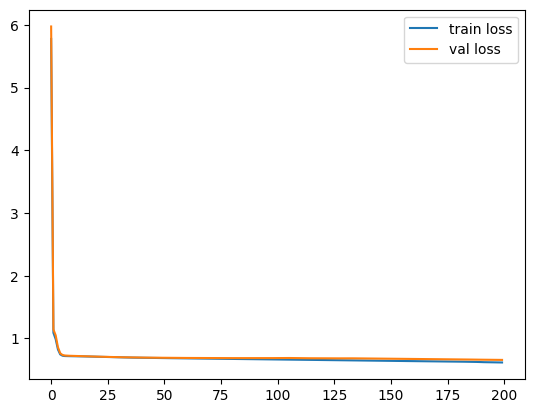

In [89]:
# plot training and validation loss over epochs
xs = [x for x in range(len(train_loss_store))]
plt.plot(xs, train_loss_store, label='train loss')
plt.plot(xs, val_loss_store, label='val loss')
plt.legend()
plt.show()

AUC 0.6810624161636485


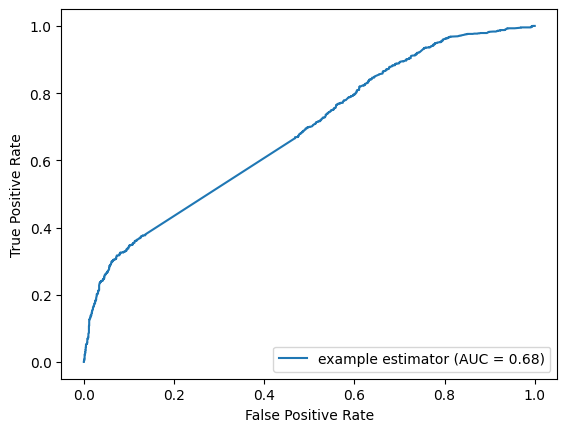

In [92]:
# Evaluate on Test Set
with torch.no_grad():
    test_pos_score = pred(test_pos_g, h)
    test_neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(test_pos_score, test_neg_score))

The AUC score is low, and the ROC-AUC curve is very poor compared to the baseline model. This is likely due to insufficient information encoded in the features. 